In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [4]:
# Neural Network structure
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.1 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
    def backward(self, dvalues):
        self.dinputs = dvalues

class Loss_MeanSquaredError:
    def calculate(self, predictions, targets):
        sample_losses = np.mean((predictions - targets) ** 2, axis=-1)
        data_loss = np.mean(sample_losses)
        return data_loss
    def backward(self, dvalues, targets):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = 2 * (dvalues - targets) / outputs
        self.dinputs = self.dinputs # / samples

In [6]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define the ODE system for the repressilator
def repressilator(t, y, degradation_rate, gene_expression_rate, repression_strength, n):
    p1, r1, p2, r2, p3, r3 = y
    
    def protein_ODE(p, r, degradation_rate):
        return - degradation_rate * (p - r)

    def mRNA_ODE(r, repressor_protein, gene_expression_rate, repression_strength, n):
        return - r + (repression_strength / (1 + repressor_protein ** n)) + gene_expression_rate

    dp1dt = protein_ODE(p1, r1, degradation_rate)
    dr1dt = mRNA_ODE(r1, p3, gene_expression_rate, repression_strength, n)

    dp2dt = protein_ODE(p2, r2, degradation_rate)
    dr2dt = mRNA_ODE(r2, p1, gene_expression_rate, repression_strength, n)

    dp3dt = protein_ODE(p3, r3, degradation_rate)
    dr3dt = mRNA_ODE(r3, p2, gene_expression_rate, repression_strength, n)

    return [dp1dt, dr1dt, dp2dt, dr2dt, dp3dt, dr3dt]

# Generate synthetic data
degradation_rate = 1  # beta
gene_expression_rate = 1  # alpha 0
repression_strength = 50  # alpha
n = 2  # Hill coefficient
t_span = (0, 200)
t_eval = np.linspace(0, 200, 200)

# Initial conditions
P1 = 10
P2 = 0
P3 = 0
R1 = 0
R2 = 0
R3 = 0
#numerical solving of system of ODEs using solve_ivp

solution = solve_ivp(repressilator, t_span, [P1, P2, P3, R1, R2, R3],t_eval = t_eval, args = (degradation_rate, gene_expression_rate, repression_strength, n))



t = solution.t
Protein_1 = solution.y[0]
Protein_2 = solution.y[1]
Protein_3 = solution.y[2]

print(Protein_1)

 

[10.          8.24615712  5.48973455  3.34764208  2.1500767   1.58990761
  1.43864237  1.7059785   2.72642498  4.96570494  8.21543043 11.01601103
 11.55483106  9.5613097   6.69601536  4.36726954  2.90497454  2.13950193
  1.87545358  2.08282608  2.95136154  4.7189336   7.13499219  9.06023054
  9.20837131  7.59735104  5.46029259  3.73948374  2.66053214  2.12851431
  2.05293136  2.49619537  3.66404869  5.60226963  7.69142595  8.71583116
  7.98965193  6.18064744  4.37343533  3.08649993  2.35698773  2.09773041
  2.30615011  3.13132837  4.7177222   6.75712834  8.24507292  8.18739427
  6.7382811   4.92427268  3.47914699  2.58166932  2.17198719  2.21037722
  2.79513332  4.09786397  6.0133593   7.76538112  8.25561606  7.20385505
  5.44756095  3.87473932  2.81854612  2.26781547  2.16462052  2.56139327
  3.62680471  5.37854725  7.26647452  8.21089588  7.5848313   5.9532159
  4.28574757  3.07860515  2.39079503  2.15887205  2.39416119  3.24054961
  4.80725075  6.74198342  8.05901136  7.87878767  6.

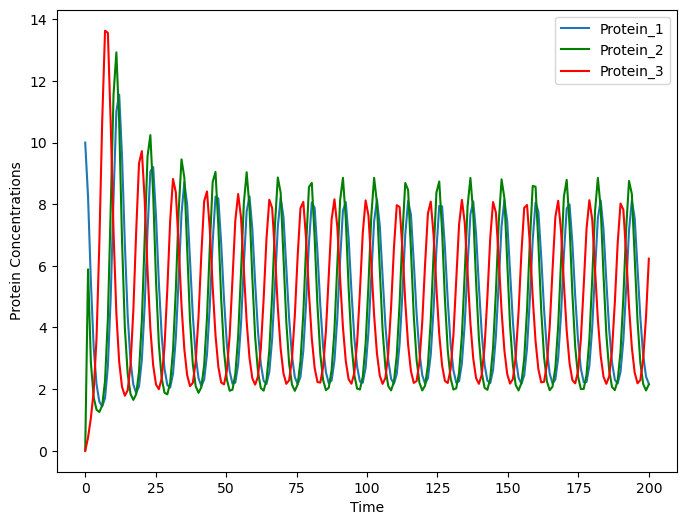

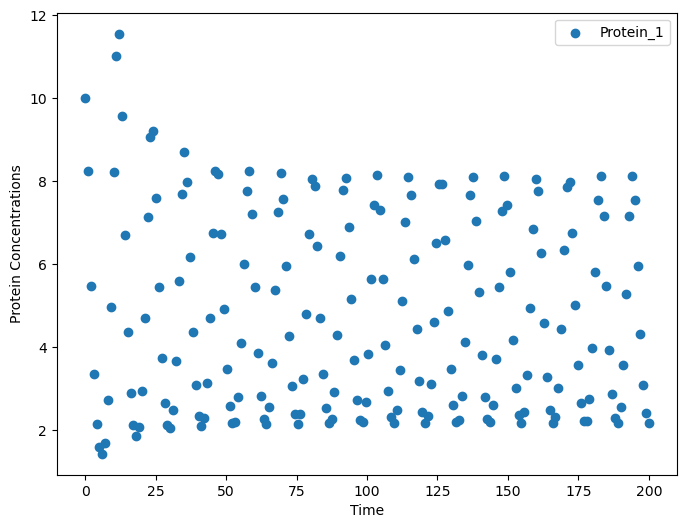

In [7]:
plt.figure(figsize = (8, 6))
plt.plot(t, Protein_1, label = "Protein_1")
plt.plot(t, Protein_2, label = "Protein_2", color = 'g')
plt.plot(t, Protein_3, label = "Protein_3", color = 'r')

plt.xlabel('Time')
plt.ylabel('Protein Concentrations')
plt.legend()
plt.show()

plt.figure(figsize = (8, 6))
plt.scatter(t, Protein_1, label = "Protein_1")
#plt.plot(t, Protein_2, label = "Protein_2", color = 'g')
#plt.plot(t, Protein_3, label = "Protein_3", color = 'r')

plt.xlabel('Time')
plt.ylabel('Protein Concentrations')
plt.legend()
plt.show()

In [8]:
# we want the network to take in the variuos initial conditions and then predict the values.
# inputs: [P1, P2, P3, R1, R2, R3]
# lets just try with one input P1
# so we want the results for P1 at lots of different initial concentrations... how do we make that dataset?
# we make the initial conditions a vector with lots of different values for P1 (initial_conditions[number of trials][0])
#then we pump the initial condition values into the model train it up with the values we predicted for time intervals 
# then use a couple examples to predict one and actually do that one to see if it is correct...


# first making the dataset
# P1, P2, P3, R1, R2, R3

initial_conditions = [[x, 0, 0, 0, 0, 0] for x in range(0, 100, 1)]
print(initial_conditions)

[[0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0], [2, 0, 0, 0, 0, 0], [3, 0, 0, 0, 0, 0], [4, 0, 0, 0, 0, 0], [5, 0, 0, 0, 0, 0], [6, 0, 0, 0, 0, 0], [7, 0, 0, 0, 0, 0], [8, 0, 0, 0, 0, 0], [9, 0, 0, 0, 0, 0], [10, 0, 0, 0, 0, 0], [11, 0, 0, 0, 0, 0], [12, 0, 0, 0, 0, 0], [13, 0, 0, 0, 0, 0], [14, 0, 0, 0, 0, 0], [15, 0, 0, 0, 0, 0], [16, 0, 0, 0, 0, 0], [17, 0, 0, 0, 0, 0], [18, 0, 0, 0, 0, 0], [19, 0, 0, 0, 0, 0], [20, 0, 0, 0, 0, 0], [21, 0, 0, 0, 0, 0], [22, 0, 0, 0, 0, 0], [23, 0, 0, 0, 0, 0], [24, 0, 0, 0, 0, 0], [25, 0, 0, 0, 0, 0], [26, 0, 0, 0, 0, 0], [27, 0, 0, 0, 0, 0], [28, 0, 0, 0, 0, 0], [29, 0, 0, 0, 0, 0], [30, 0, 0, 0, 0, 0], [31, 0, 0, 0, 0, 0], [32, 0, 0, 0, 0, 0], [33, 0, 0, 0, 0, 0], [34, 0, 0, 0, 0, 0], [35, 0, 0, 0, 0, 0], [36, 0, 0, 0, 0, 0], [37, 0, 0, 0, 0, 0], [38, 0, 0, 0, 0, 0], [39, 0, 0, 0, 0, 0], [40, 0, 0, 0, 0, 0], [41, 0, 0, 0, 0, 0], [42, 0, 0, 0, 0, 0], [43, 0, 0, 0, 0, 0], [44, 0, 0, 0, 0, 0], [45, 0, 0, 0, 0, 0], [46, 0, 0, 0, 0, 0], [47, 0, 0, 0, 0, 0], [